# Proyecto 1: Entrega 1 - BI

| ID | Nombre           | Código    | Correo                       |
|----|------------------|-----------|------------------------------|
| 1  | Adrian Velasquez | 202222737 | a.velasquezs@uniandes.edu.co |
| 2  | xxx              | xxx       | xxx@uniandes.edu.co          |
| 3  | yyy              | yyy       | yyy@uniandes.edu.co          |

In [184]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import ComplementNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn import tree

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [185]:
TRAIN = "data/train_data.xlsx"
TEST = "data/test_data.xlsx"

## Entendimiento y perfilamiento de los datos

De forma preliminar, sabemos que el objetivo de nuestro modelo es categorizar las opiniones de acuerdo a los ODS (objetivos de desarrollo sostenible) 1, 3 y 4, los cuales son “Fin de la pobreza”, “Salud y bienestar” y “Educación de calidad” respectivamente. En primer lugar, haremos un análisis preliminar de los datos, la calidad de los mismos, y validaremos cualquier caso particular que encontremos.

In [186]:
df_original = pd.read_excel(TRAIN)
df_original.head()

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


In [187]:
df_original.shape

(2424, 2)

In [188]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


In [189]:
print(df_original.isnull().sum())

textos    0
labels    0
dtype: int64


In [190]:
print(df_original.duplicated().sum())

0


Podemos ver una completitud en los datos, pues no hay nulos en ninguno de los entries en ninguna de las dos columnas. Asimismo, no hay duplicados completos, lo cual es una buena señal. Ahora nos centraremos a comprender cada columna por separado

### Columna textos

In [191]:
print(df_original["textos"].duplicated().sum())

0


Toca convertir la columna de textos a tipo string, con el fin de poderla manipular adecuadamente y hacer un análisis más riguroso.

In [192]:
df_original["textos"] = df_original["textos"].astype("string")
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   string
 1   labels  2424 non-null   int64 
dtypes: int64(1), string(1)
memory usage: 38.0 KB


In [193]:
df_text_analysis = df_original.copy()

In [194]:
df_text_analysis["textos_lower"] = df_text_analysis["textos"].str.lower()
df_text_analysis.head()

,textos,labels,textos_lower
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,"""aprendizaje"" y ""educación"" se consideran sinó..."
1,Para los niños más pequeños (bebés y niños peq...,4,para los niños más pequeños (bebés y niños peq...
2,"Además, la formación de especialistas en medic...",3,"además, la formación de especialistas en medic..."
3,En los países de la OCDE se tiende a pasar de ...,4,en los países de la ocde se tiende a pasar de ...
4,Este grupo se centró en las personas que padec...,3,este grupo se centró en las personas que padec...


In [195]:
print(df_text_analysis["textos_lower"].duplicated().sum())

0


Podemos ver que incluso cuando todas las entries de la columna han sido normalizadas de tal manera que están en minúscula, no hay duplicados entre ellas.

In [196]:
df_text_analysis["textos_lower_split"] = df_text_analysis["textos_lower"].str.replace("(","").str.replace(")","").str.replace('"', "").str.replace(",","").str.split(" ")
df_text_analysis.head()

,textos,labels,textos_lower,textos_lower_split
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,"""aprendizaje"" y ""educación"" se consideran sinó...","[aprendizaje, y, educación, se, consideran, si..."
1,Para los niños más pequeños (bebés y niños peq...,4,para los niños más pequeños (bebés y niños peq...,"[para, los, niños, más, pequeños, bebés, y, ni..."
2,"Además, la formación de especialistas en medic...",3,"además, la formación de especialistas en medic...","[además, la, formación, de, especialistas, en,..."
3,En los países de la OCDE se tiende a pasar de ...,4,en los países de la ocde se tiende a pasar de ...,"[en, los, países, de, la, ocde, se, tiende, a,..."
4,Este grupo se centró en las personas que padec...,3,este grupo se centró en las personas que padec...,"[este, grupo, se, centró, en, las, personas, q..."


In [197]:
df_text_analysis["len_texts"] = df_text_analysis["textos_lower_split"].str.len()

df_text_analysis["len_texts"].describe()

count    2424.000000
mean      107.953795
std        35.578358
min        41.000000
25%        81.000000
50%       102.000000
75%       129.000000
max       260.000000
Name: len_texts, dtype: float64

In [198]:
df_text_analysis.shape

(2424, 5)

In [199]:
print(len(df_text_analysis["len_texts"].unique()))

184


### Columna label (target)

In [200]:
df_original['labels'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2424 entries, 0 to 2423
Series name: labels
Non-Null Count  Dtype
--------------  -----
2424 non-null   int64
dtypes: int64(1)
memory usage: 19.1 KB


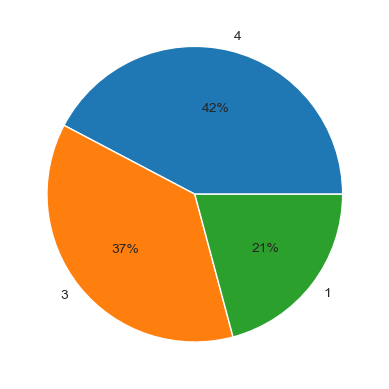

In [201]:
plt.pie(df_original['labels'].value_counts(), labels=df_original['labels'].unique(), autopct='%1.0f%%')
plt.show()

### Duplicados parciales

En general, no se observaron duplicados parciales. Hay textos cuya longitud es equivalente, sin embargo, no son idénticos.

## Preparación de los datos

In [202]:
df = df_original.copy()
df.head()

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


Ahora que tenemos un dataframe sobre el cual podemos trabajar, ejecutaremos un TfidVectorizer para garantizar que las palabras tokenizadas sean adecuadamente analizadas con base en en el TF-IDF, para medir la importancia de ciertas palabras en comparación a los demás textos.

In [203]:
spanish_sw = list(stopwords.words("spanish"))

def clean_text(s):
    s = s.replace("\n", " ").replace("(", " ").replace(")", " ").replace(",", "")
    s = s.lower()
    return s

tfidf_word = TfidfVectorizer(
    preprocessor=clean_text,
    stop_words=spanish_sw,
    ngram_range=(1,2),
    max_df=0.9,
    min_df=3,
    max_features=20000,
    sublinear_tf=True
)


Más allá del vectorizer, como vimos en el entendimiento y perfilamiento de los datos, no hay mucho que hacer antes de seguir con la construcción de los modelos.

## Construcción de los modelos

### Preparación inicial

En general, debido a que en el vectorizer incluimos un preprocesador para la limpieza de los textos y la eliminación de los stopwords, no es necesario hacer muchos procedimientos de forma manual.

In [204]:
x = df["textos"]
y = df["labels"]

x_train, x_test, y_train, y_test = train_test_split(x, y)

In [205]:
def evaluate_classifier(f_y_test, f_y_pred):
    return 0

### Modelo 1: LinearSVC

El primer modelo que utilizaremos es el LinearSVC, pues es un modelo estándar de la librería SciKit Learn que es utilizado para tareas de clasificación.

In [206]:
pipe_linear_svm = Pipeline([
    ("vector", tfidf_word),
    ("clf", LinearSVC(class_weight="balanced", random_state=42))
])

In [207]:
pipe_linear_svm.fit(x_train, y_train)

,steps,"[('vector', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,<function cle...t 0x312aef600>
,tokenizer,None


In [208]:
pred_linear_svm = pipe_linear_svm.predict(x_test)

In [209]:
cm_linear_svm = confusion_matrix(y_test, pred_linear_svm)

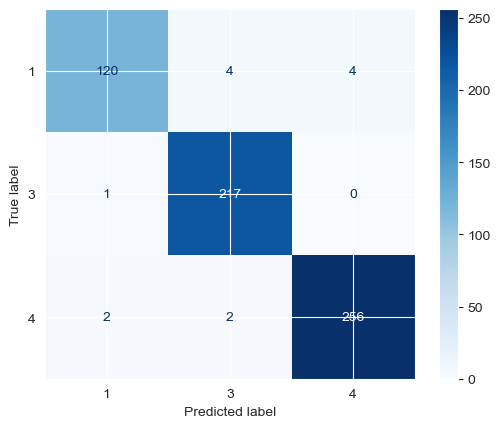

In [210]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_linear_svm, display_labels=pipe_linear_svm.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [211]:
print(classification_report(y_test, pred_linear_svm))

              precision    recall  f1-score   support

           1       0.98      0.94      0.96       128
           3       0.97      1.00      0.98       218
           4       0.98      0.98      0.98       260

    accuracy                           0.98       606
   macro avg       0.98      0.97      0.97       606
weighted avg       0.98      0.98      0.98       606



### Modelo 2: DecisionTreeClassifier

In [212]:
pipe_dec_tree = Pipeline([
    ("vector", tfidf_word),
    ("clf", DecisionTreeClassifier(random_state=42,class_weight="balanced"))
])

In [213]:
pipe_dec_tree.fit(x_train, y_train)

,steps,"[('vector', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,<function cle...t 0x312aef600>
,tokenizer,None


In [214]:
pred_dec_tree = pipe_dec_tree.predict(x_test)

In [215]:
cm_dec_tree = confusion_matrix(y_test, pred_dec_tree)

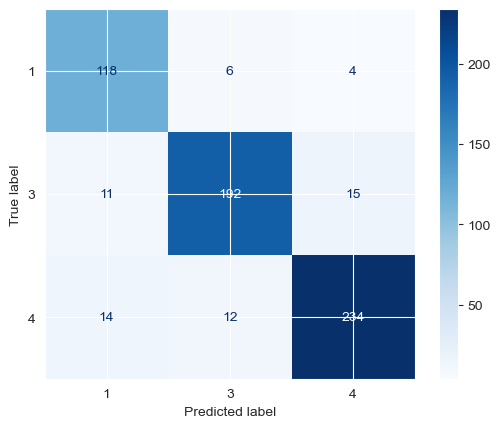

In [216]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dec_tree, display_labels=pipe_dec_tree.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [217]:
print(classification_report(y_test, pred_dec_tree))

              precision    recall  f1-score   support

           1       0.83      0.92      0.87       128
           3       0.91      0.88      0.90       218
           4       0.92      0.90      0.91       260

    accuracy                           0.90       606
   macro avg       0.89      0.90      0.89       606
weighted avg       0.90      0.90      0.90       606



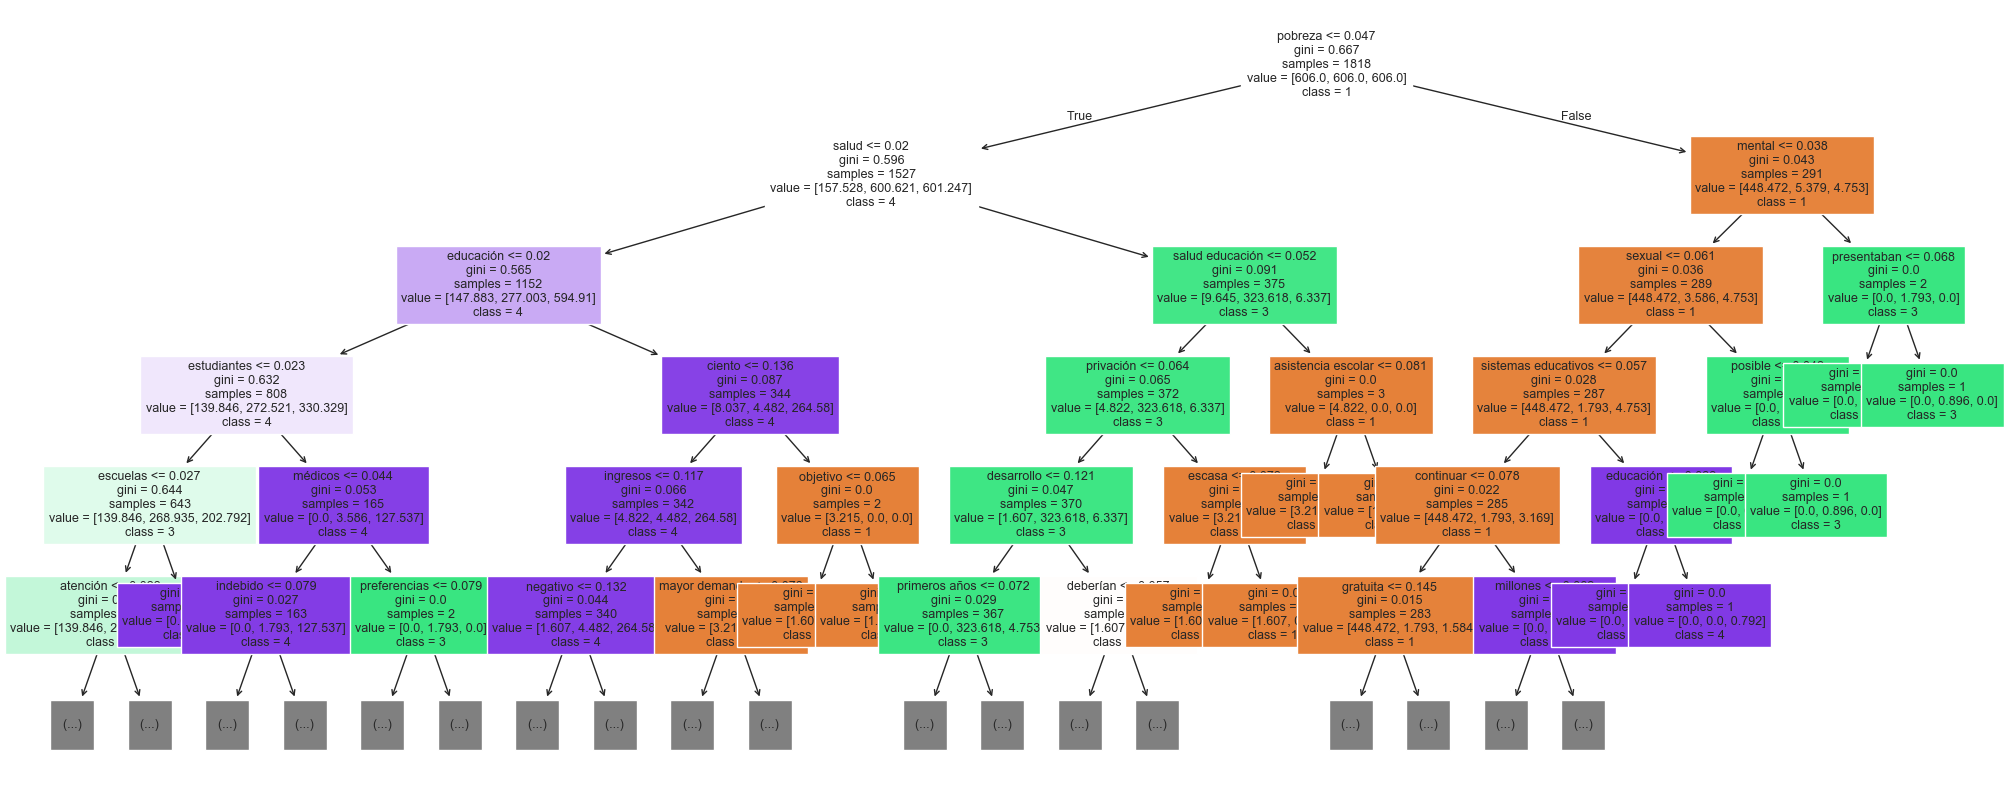

In [218]:
dec_tree = pipe_dec_tree.named_steps["clf"]
tfidf_vectorizer = pipe_dec_tree.named_steps["vector"]

fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(dec_tree, max_depth=5 if dec_tree.tree_.max_depth > 5 else 2, feature_names=tfidf_vectorizer.get_feature_names_out(), class_names=["1", "3", "4"], filled=True, fontsize=9)

### Modelo 3: Naive Bayes

In [219]:
pipe_comp_nb = Pipeline([
    ("vector", tfidf_word),
    ("clf", ComplementNB())
])

In [220]:
pipe_comp_nb.fit(x_train, y_train)

,steps,"[('vector', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,<function cle...t 0x312aef600>
,tokenizer,None


In [221]:
pred_comb_nb = pipe_comp_nb.predict(x_test)

In [222]:
cm_comp_nb = confusion_matrix(y_test, pred_comb_nb)

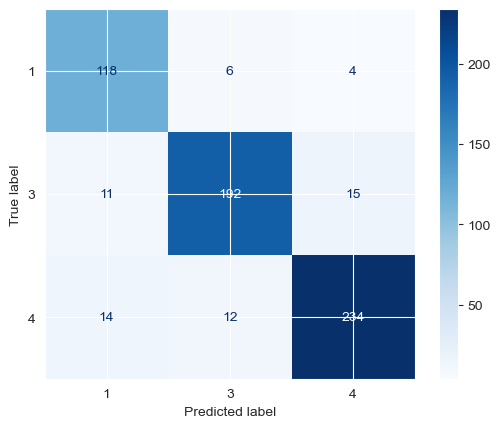

In [223]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dec_tree, display_labels=pipe_comp_nb.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [224]:
print(classification_report(y_test, pred_comb_nb))

              precision    recall  f1-score   support

           1       0.96      0.93      0.94       128
           3       0.97      0.97      0.97       218
           4       0.97      0.98      0.98       260

    accuracy                           0.97       606
   macro avg       0.97      0.96      0.96       606
weighted avg       0.97      0.97      0.97       606



### Búsqueda de parámetros

Pese a que los resultados de los 3 modelos en general fueron satisfactorios, intentaremos mejorarlos aún más utilizando GridSearchCV con el fin de garantizar un modelo todavía mejor

In [225]:
cv_tree = KFold(n_splits=10, shuffle=True, random_state = 0)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = "f1_macro"

In [226]:
param_svm = {"clf__C": [0.5, 1, 2]}
param_tree = {'clf__criterion':['gini', 'entropy'],'clf__max_depth':[4,6,8,10,20]}
param_nb  = {"clf__alpha": [0.5, 1.0, 2.0]}

In [227]:
mejor_pipe_linear_svm = GridSearchCV(
    estimator=pipe_linear_svm,
    param_grid=param_svm,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    verbose=1,
)
mejor_pipe_linear_svm.fit(x_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'clf__C': [0.5, 1, ...]}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


In [228]:
mejor_pipe_dec_tree = GridSearchCV(
    estimator=pipe_dec_tree,
    param_grid=param_tree,
    scoring=scoring,
    cv=cv_tree,
    n_jobs=-1,
    verbose=1
)
mejor_pipe_dec_tree.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'clf__criterion': ['gini', 'entropy'], 'clf__max_depth': [4, 6, ...]}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


### Selección del mejor modelo

In [229]:
mejor_pipe_comp_nb = gnb = GridSearchCV(
    estimator=pipe_comp_nb,
    param_grid=param_nb,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    verbose=1
)
mejor_pipe_comp_nb.fit(x_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,estimator,Pipeline(step...plementNB())])
,param_grid,"{'clf__alpha': [0.5, 1.0, ...]}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


In [230]:
def summarize(gs, name):
    df = pd.DataFrame(gs.cv_results_)
    cols = ["mean_test_score", "std_test_score", "params", "rank_test_score"]
    out = df[cols].sort_values("rank_test_score").copy()
    out.insert(0, "modelo", name)
    return out

In [231]:
tbl = pd.concat([
    summarize(mejor_pipe_linear_svm, "LinearSVC"),
    summarize(mejor_pipe_dec_tree, "DecTree"),
    summarize(mejor_pipe_comp_nb, "ComplNB")
], ignore_index=True)

display(tbl.head(10))
best_global = max(
    [("LinearSVC", mejor_pipe_linear_svm), ("DecTree", mejor_pipe_dec_tree), ("ComplNB", mejor_pipe_comp_nb)],
    key=lambda t: t[1].best_score_
)
best_name, best_gs = best_global
print("Mejor modelo:", best_name, " | F1-macro CV:", round(best_gs.best_score_, 4))
print("Mejores params:", best_gs.best_params_)

,modelo,mean_test_score,std_test_score,params,rank_test_score
0,LinearSVC,0.977293,0.009365,{'clf__C': 2},1
1,LinearSVC,0.976608,0.008991,{'clf__C': 0.5},2
2,LinearSVC,0.976173,0.009003,{'clf__C': 1},3
3,DecTree,0.899925,0.019083,"{'clf__criterion': 'entropy', 'clf__max_depth'...",1
4,DecTree,0.896564,0.028230,"{'clf__criterion': 'gini', 'clf__max_depth': 20}",2
5,DecTree,0.878039,0.032349,"{'clf__criterion': 'gini', 'clf__max_depth': 10}",3
6,DecTree,0.866902,0.033970,"{'clf__criterion': 'entropy', 'clf__max_depth'...",4
7,DecTree,0.860918,0.027558,"{'clf__criterion': 'gini', 'clf__max_depth': 8}",5
8,DecTree,0.856340,0.033183,"{'clf__criterion': 'entropy', 'clf__max_depth'...",6
9,DecTree,0.819503,0.028201,"{'clf__criterion': 'entropy', 'clf__max_depth'...",7


Mejor modelo: LinearSVC  | F1-macro CV: 0.9773
Mejores params: {'clf__C': 2}


Podemos ver que el mejor modelo, en general, fue el LinearSVC cuyo hiperparámetro C equivale a `1`, con resultados similares en los demás LinearSVC con hiperparámetros son `2` y `0.5` respectivamente. Este será el modelo escogido, y será el que utilizaremos de ahora en adelante.

In [232]:
pipe_best = mejor_pipe_linear_svm.best_estimator_
MODEL = "models/modelo.joblib"
joblib.dump(pipe_best, MODEL)
print(f"Mejor modelo guardado en {MODEL}")

Mejor modelo guardado en models/modelo.pkl


## Etiquetamiento del conjunto de prueba

## Resultados

## Trabajo en equipo